In [1]:
# !pip install PyDrive
# !pip install gensim
# !pip install pyldavis
# !python -m spacy download en
# !pip install nltk

In [3]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# from google.colab import auth
from oauth2client.client import GoogleCredentials
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lijiaxiang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [5]:
# download = drive.CreateFile({'id': '1-a2dbUDDHsmkWOXoDYvgvCa8WBkEMzbr'})

In [6]:
# ls

In [7]:
# download.GetContentFile('automotive_rev_json.gz')

In [8]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [10]:
df = getDF('reviews_Automotive_5.json.gz')
df.shape

(20473, 9)

In [11]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car and these had good reviews and were at a good price. They have been used a few times already and do what they are supposed to - no complaints there....,5.0,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but the quality seems a little on the shabby side. For the money I was not expecting 200 dollar snap-on jumper cables but these seem more like what you wo...",4.0,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]","Can't comment much on these since they have not yet been used (I will come back and update my review is I find any issues after first use) ... but they are built solid, nice tough big hard clamps ...",5.0,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]","I absolutley love Amazon!!! For the price of a set of cheap Booster/Jumper Cables in a brick and morter store, you can buy extra long and heavy duty jumpers! First off, don't be the person that ...",5.0,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]","I purchased the 12' feet long cable set and they arrived in a retail cardboard box with handle, which could be used as a storage and carrying case for these cables, although I will not need to sto...",5.0,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


In [12]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

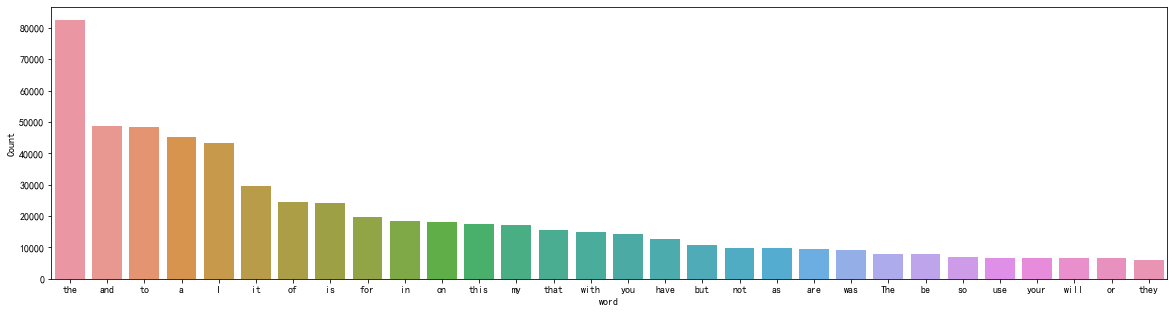

In [13]:
freq_words(df['reviewText'])

In [14]:
# replace "n't" with " not"
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

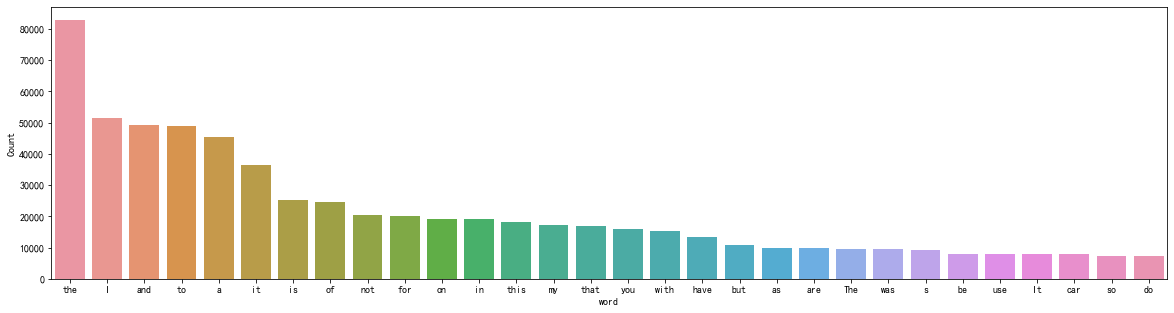

In [15]:
freq_words(df['reviewText'])

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [17]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [18]:
# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

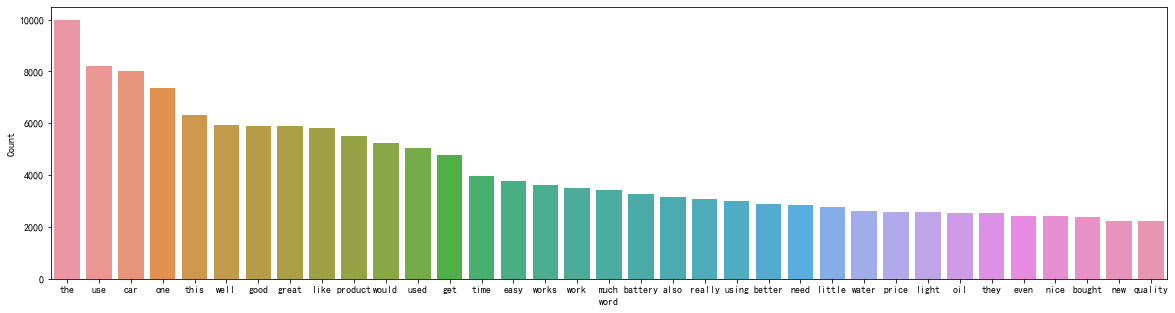

In [19]:
freq_words(reviews, 35)

In [21]:
# nlp = spacy.load('en', disable=['parser', 'ner'])

In [22]:
# def lemmatization(texts, tags=['NOUN', 'ADJ']):
#     output = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         output.append([token.lemma_ for token in doc if token.pos_ in tags])
#     return output

In [23]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [24]:
print(tokenized_reviews[1])
len(tokenized_reviews[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


29

In [26]:
# reviews_2 = lemmatization(tokenized_reviews)
reviews_2 = tokenized_reviews
print(reviews_2[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


In [27]:
print(reviews_2[1])
len(reviews_2[1])

['these', 'long', 'cables', 'work', 'fine', 'truck', 'quality', 'seems', 'little', 'shabby', 'side', 'for', 'money', 'expecting', 'dollar', 'snap', 'jumper', 'cables', 'seem', 'like', 'would', 'see', 'chinese', 'knock', 'shop', 'like', 'harbor', 'freight', 'bucks']


29

In [28]:
set(tokenized_reviews[1]) - set(reviews_2[1])

set()

In [29]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

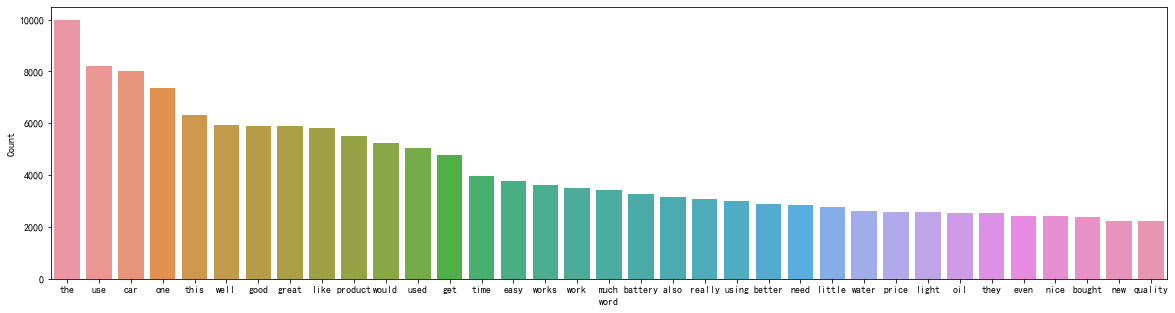

In [30]:
freq_words(df['reviews'], 35)

In [31]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [32]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [33]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [34]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)
# 执行时间很长

In [38]:
lda_model.print_topics()

[(0,
  '0.019*"brush" + 0.019*"wheels" + 0.016*"wheel" + 0.012*"ice" + 0.011*"snow" + 0.008*"carpet" + 0.007*"cold" + 0.006*"rust" + 0.006*"cup" + 0.006*"metal"'),
 (1,
  '0.020*"great" + 0.019*"well" + 0.018*"wiper" + 0.016*"blade" + 0.016*"blades" + 0.015*"easy" + 0.013*"good" + 0.012*"they" + 0.012*"fit" + 0.011*"windshield"'),
 (2,
  '0.019*"the" + 0.011*"light" + 0.010*"one" + 0.009*"would" + 0.007*"get" + 0.007*"like" + 0.006*"use" + 0.006*"lights" + 0.006*"this" + 0.005*"well"'),
 (3,
  '0.022*"car" + 0.013*"product" + 0.013*"use" + 0.011*"the" + 0.010*"like" + 0.009*"used" + 0.008*"wax" + 0.008*"good" + 0.008*"great" + 0.008*"this"'),
 (4,
  '0.013*"car" + 0.012*"one" + 0.008*"price" + 0.008*"the" + 0.008*"product" + 0.007*"good" + 0.007*"oil" + 0.007*"time" + 0.007*"amazon" + 0.007*"get"'),
 (5,
  '0.031*"battery" + 0.020*"power" + 0.015*"car" + 0.014*"use" + 0.012*"plug" + 0.011*"unit" + 0.011*"charge" + 0.010*"the" + 0.010*"charger" + 0.009*"this"'),
 (6,
  '0.039*"hose" + 0

In [36]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
# vis

D:\install\miniconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.147942 -0.035721       1        1  29.875761
3     -0.149865  0.013976       2        1  23.312880
4     -0.157077 -0.007677       3        1  19.591799
1     -0.134366 -0.073014       4        1  10.277308
5     -0.029176  0.028714       5        1   9.309188
6      0.244409  0.315891       6        1   4.298226
0      0.374018 -0.242169       7        1   3.334835, topic_info=     Category         Freq      Term        Total  loglift  logprob
892   Default  2847.000000     water  2847.000000  30.0000  30.0000
70    Default  2629.000000   battery  2629.000000  29.0000  29.0000
7     Default  8321.000000       car  8321.000000  28.0000  28.0000
1271  Default  1522.000000      hose  1522.000000  27.0000  27.0000
114   Default  1639.000000     power  1639.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
1218   Topic7   130.549881     floor   336.822327   2.4529  -5.4391
383    Topic7   155.008377    handle   733.728516   1.8461  -5.2674
2709   Topic7   136.396820    winter   497.256989   2.1072  -5.3953
443    Topic7    93.466354  aluminum   155.107880   2.8942  -5.7733
818    Topic7    92.322762  material   388.181488   1.9646  -5.7856

[436 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4562       4  0.161651   adapter
4562       5  0.835907   adapter
5878       6  0.997492  adapters
3473       1  0.996263  adhesive
861        1  0.381670       air
...      ...       ...       ...
569        2  0.317594     years
569        3  0.522313     years
569        4  0.083430     years
569        5  0.060294     years
24299      3  0.997099     zubie

[676 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 2, 6, 7, 1])

## save model

In [40]:
lda_model.__class__

gensim.models.ldamodel.LdaModel

参考 https://radimrehurek.com/gensim/models/ldamodel.html

In [41]:
lda_model.save("model/lda.model")

In [44]:
lda_model2 = gensim.models.ldamodel.LdaModel.load("model/lda.model")

In [46]:
lda_model2.print_topics()

[(0,
  '0.019*"brush" + 0.019*"wheels" + 0.016*"wheel" + 0.012*"ice" + 0.011*"snow" + 0.008*"carpet" + 0.007*"cold" + 0.006*"rust" + 0.006*"cup" + 0.006*"metal"'),
 (1,
  '0.020*"great" + 0.019*"well" + 0.018*"wiper" + 0.016*"blade" + 0.016*"blades" + 0.015*"easy" + 0.013*"good" + 0.012*"they" + 0.012*"fit" + 0.011*"windshield"'),
 (2,
  '0.019*"the" + 0.011*"light" + 0.010*"one" + 0.009*"would" + 0.007*"get" + 0.007*"like" + 0.006*"use" + 0.006*"lights" + 0.006*"this" + 0.005*"well"'),
 (3,
  '0.022*"car" + 0.013*"product" + 0.013*"use" + 0.011*"the" + 0.010*"like" + 0.009*"used" + 0.008*"wax" + 0.008*"good" + 0.008*"great" + 0.008*"this"'),
 (4,
  '0.013*"car" + 0.012*"one" + 0.008*"price" + 0.008*"the" + 0.008*"product" + 0.007*"good" + 0.007*"oil" + 0.007*"time" + 0.007*"amazon" + 0.007*"get"'),
 (5,
  '0.031*"battery" + 0.020*"power" + 0.015*"car" + 0.014*"use" + 0.012*"plug" + 0.011*"unit" + 0.011*"charge" + 0.010*"the" + 0.010*"charger" + 0.009*"this"'),
 (6,
  '0.039*"hose" + 0

把相关规则进行存储。